In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=3,style='whitegrid')

In [111]:
iic_burden['Cname']

['Gender',
 'Age',
 'Marrital',
 'iGCS-Total',
 'iGCS = T?',
 'Worst GCS in 1st 24h',
 'Worst GCS intub',
 'APACHE II 1st 24h',
 'SBP highest (1st 24h)',
 'SBP lowest (1st 24h)',
 'DBP highest (1st 24h)',
 'DBP lowest (1st 24h)',
 'HR highest (1std 24h)',
 'HR lowest (1st 24h)',
 'Surgery',
 'Hx CVA',
 'Hx HTN',
 'Hx Sz',
 'Hx brain surgery',
 'Hx CKD',
 'Hx CAD/MI',
 'Hx CHF',
 'Hx DM',
 'Hx HLD',
 'Hx PUD',
 'Hx liver failure',
 'Hx smoking',
 'Hx alcohol',
 'Hx substance abuse',
 'Hx cancer',
 'Hx CNS cancer',
 'Hx PVD',
 'Hx dementia',
 'Hx COPD/Asthma',
 'Hx leukemia/lymphoma',
 'Hx AIDs',
 'Hx CTD',
 'premorbid MRS',
 'OSH time 1st AED',
 'CA (PEA)',
 'Sz at presentation',
 'EEG day1 MV',
 'EEG day1 GCS',
 'EEG day1 sysBP',
 'acute SDH',
 'Sepsis/Shock',
 'NeuroDx:IschStroke',
 'NeuroDx:HemStroke',
 'NeuroDx:SAH',
 'NeuroDx:SDH',
 'NeuroDx:SDH+TBI(SAH)',
 'NeuroDx:TBI(SAH)',
 'NeuroDx:Sz/SE',
 'NeuroDx:Brain tumor',
 'NeuroDx:CNS infection',
 'NeuroDx:HIE/ABI',
 'NeuroDx:TME',
 '

In [2]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

In [20]:
df_coarsen = setup_coarsen_data(iic_burden,window = 6,summarize='max')
df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
                     index_col=0, header=0)
df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
                   'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)
df_coarsen_1 = df_coarsen[iic_burden['Cname']+['mRS', 'E'
                                               ,'lacosamide', 'levetiracetam', 'midazolam', 
                                               'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')
continuous = ['Age','iGCS-Total','iGCS = T?','Worst GCS in 1st 24h','Worst GCS intub','APACHE II 1st 24h',
              'SBP highest (1st 24h)','SBP lowest (1st 24h)','DBP highest (1st 24h)','DBP lowest (1st 24h)',
              'HR highest (1std 24h)','HR lowest (1st 24h)','premorbid MRS']
discrete = set(iic_burden['Cname']).difference(continuous)

df_coarsen_1['Y'] = (df_coarsen_1['mRS'] > 3).astype(float)

n_thresholds = 5
thresholds = [0,0.25,0.5,0.75,1]#list(np.linspace(0,1,num=n_thresholds))
gain = thresholds[1]-thresholds[0]
iic_level = df_coarsen_1['E']>2
for threshold in thresholds:
    iic_level = iic_level + gain*(df_coarsen_1['E']>threshold).astype(int)
    
iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)
drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
              (df_coarsen_1['propofol']>1) + 
              (df_coarsen_1['midazolam']>0) +
              (df_coarsen_1['lacosamide']>0) +
              (df_coarsen_1['pentobarbital']>0) +
              (df_coarsen_1['phenobarbital']>0) +
              (df_coarsen_1['valproate']>0) ).astype(int)

df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
df_coarsen_1['drug'] = drug_level
df_coarsen_1['T'] = '('+df_coarsen_1['iic'].astype(str) +', '+df_coarsen_1['drug'].astype(str)+')'

<AxesSubplot:ylabel='Frequency'>

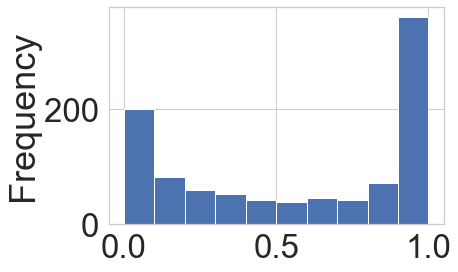

In [21]:
df_coarsen_1['E'].plot(kind='hist')

In [22]:
df_coarsen_1.groupby(by='T').mean()

,Gender,Age,Marrital,iGCS-Total,iGCS = T?,Worst GCS in 1st 24h,Worst GCS intub,APACHE II 1st 24h,SBP highest (1st 24h),SBP lowest (1st 24h),...,alpha[2],b[lacosamide],b[levetiracetam],b[midazolam],b[pentobarbital],b[phenobarbital],b[propofol],b[valproate],Y,drug
T,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0)",0.888889,50.561111,0.444444,7.111111,0.777778,5.444444,0.888889,24.555556,184.333333,123.888889,...,0.173804,0.000000,0.000000,0.000000,0.000000,0.000000,2.543090,0.000000,0.888889,0
"(0.0, 1)",0.730769,57.662692,0.423077,7.384615,0.730769,5.346154,0.923077,23.923077,165.307692,114.230769,...,0.188547,0.351080,4.562006,3.100338,0.000000,0.060002,18.481702,0.000000,0.692308,1
"(0.12, 0)",0.421053,58.490000,0.526316,11.631579,0.210526,11.052632,0.250000,14.118421,152.289474,118.736842,...,0.189789,0.000000,0.339545,0.000000,0.000000,0.000000,0.568062,0.000000,0.605263,0
"(0.12, 1)",0.484694,59.178010,0.464286,8.933673,0.551020,6.806122,0.693878,19.846939,159.877551,117.010204,...,0.168586,1.902774,4.322856,2.742555,0.000000,0.505957,11.613752,0.474122,0.775510,1
"(0.38, 0)",0.500000,57.380500,0.525000,12.025000,0.200000,11.000000,0.250000,13.775000,157.675000,115.375000,...,0.191995,0.000000,0.311133,0.000000,0.000000,0.000000,0.001661,0.000000,0.700000,0
"(0.38, 1)",0.488889,59.398556,0.433333,9.800000,0.466667,8.288889,0.522222,17.688889,155.244444,118.000000,...,0.108746,0.300149,2.660115,2.571180,0.056168,0.000839,6.901892,0.096524,0.800000,1
"(0.62, 0)",0.363636,63.777576,0.545455,12.666667,0.272727,11.363636,0.303030,14.121212,153.484848,122.575758,...,0.247646,0.000000,0.642044,0.000000,0.000000,0.000000,0.000000,0.000000,0.606061,0
"(0.62, 1)",0.418919,62.647432,0.418919,9.175676,0.459459,7.851351,0.527027,19.310811,162.067568,116.945946,...,0.146539,0.523477,2.374695,3.062368,0.000000,0.424581,4.278720,0.867698,0.878378,1
"(0.88, 0)",0.483871,61.140565,0.556452,12.080645,0.185484,10.782258,0.241935,14.911290,153.483871,121.258065,...,0.241574,0.000000,0.554537,0.000000,0.000000,0.000000,0.988717,0.000000,0.750000,0


## Controlling for age

In [23]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

In [24]:
list(m.CATE_df.columns.unique())

['Y((0.88, 1))',
 'Y((0.12, 1))',
 'Y((0.88, 0))',
 'Y((0.62, 0))',
 'Y((0.62, 1))',
 'Y((0.38, 1))',
 'Y((0.12, 0))',
 'Y((0.38, 0))',
 'Y((0.0, 0))',
 'Y((0.0, 1))',
 'diameter((0.88, 1))',
 'diameter((0.12, 1))',
 'diameter((0.88, 0))',
 'diameter((0.62, 0))',
 'diameter((0.62, 1))',
 'diameter((0.38, 1))',
 'diameter((0.12, 0))',
 'diameter((0.38, 0))',
 'diameter((0.0, 0))',
 'diameter((0.0, 1))',
 'Y',
 'T']

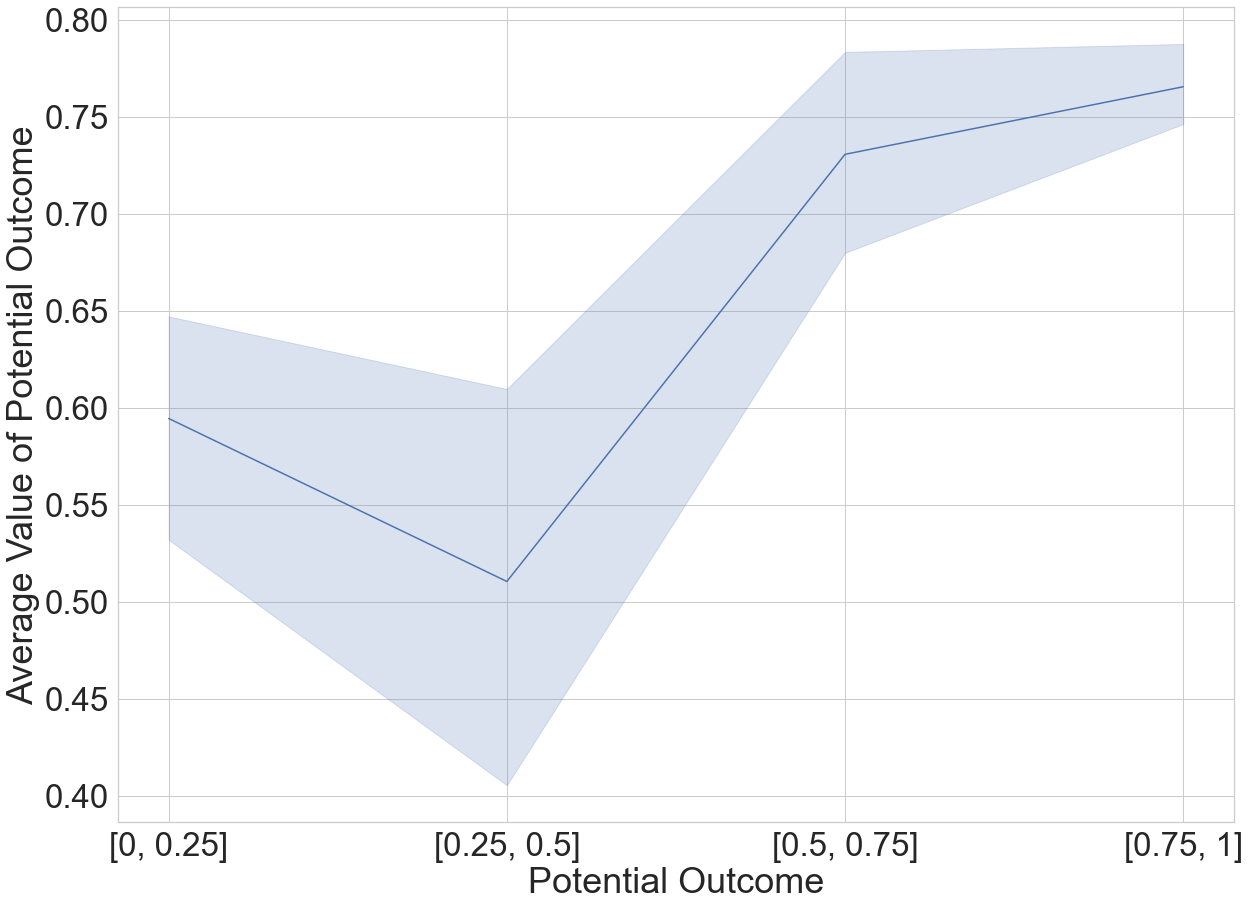

In [25]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_max_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0 = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1 = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0 = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1 = out[columns]

apo_tight_0 = pd.DataFrame(apo_0.values*(diam_0<1).astype(int).replace(0, np.nan).values,
                         index=apo_0.index,columns=apo_0.columns)
apo_tight_0.mean(axis=0)

apo_tight_1 = pd.DataFrame(apo_1.values*(diam_1<1).astype(int).replace(0, np.nan).values,
                         index=apo_1.index,columns=apo_0.columns)
apo_tight_1.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_age.png')

## Controlling for All Preadmission Covariates

In [59]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))

m_c = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

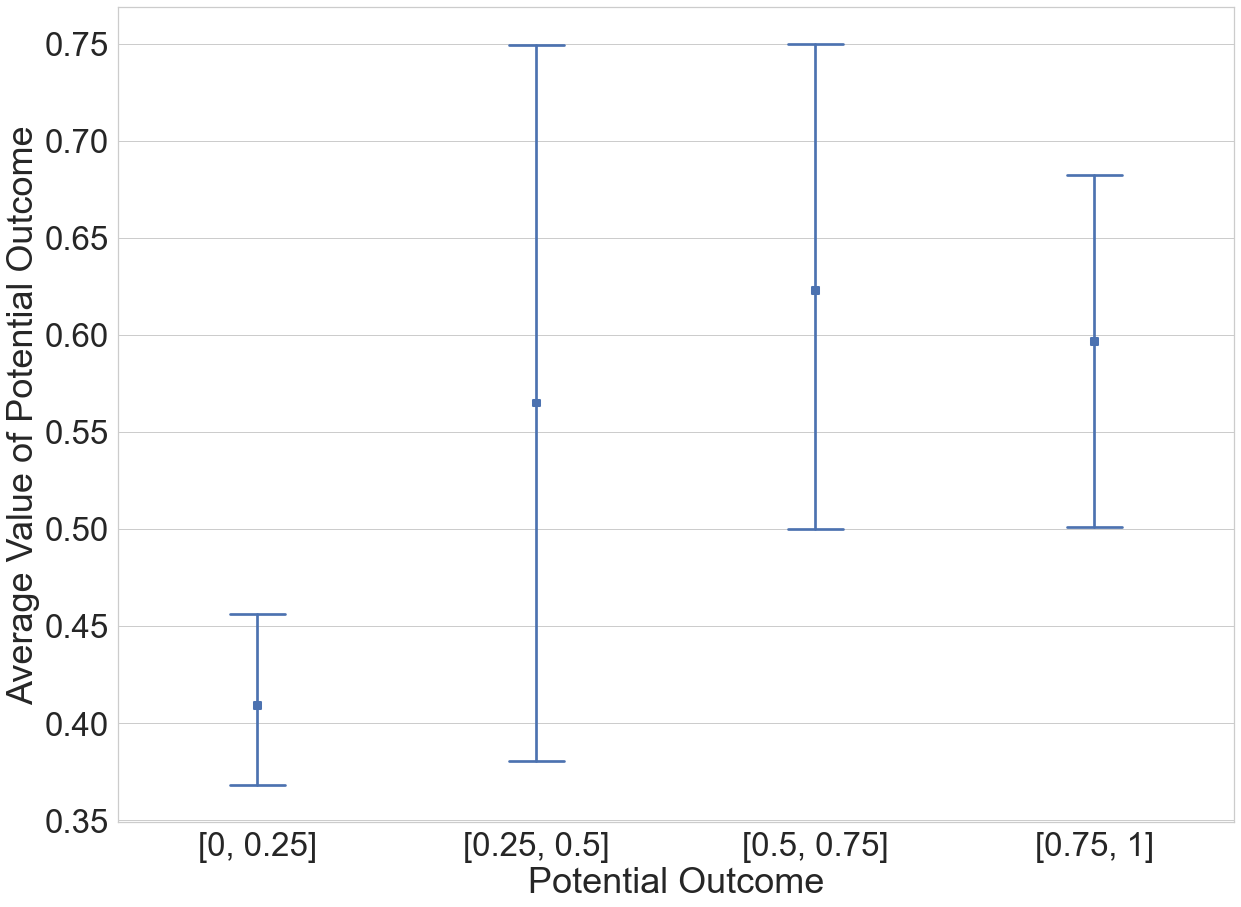

In [60]:
out_c = m_c.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_max_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_c.png')

# Controlling for all pre-admission covariates and PKPD parameters

In [37]:
n_repeats = 50
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['b[lacosamide]', 'b[levetiracetam]',
                            'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 
                            'b[propofol]','b[valproate]','Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=3,
                k_est=5,
                discrete = discrete,
                C=0.01)

SBP lowest (1st 24h)    0.308828
APACHE II 1st 24h       0.280720
DBP lowest (1st 24h)    0.293370
iGCS-Total              0.283501
Worst GCS in 1st 24h    0.268165
                          ...   
Hx CNS cancer           0.139763
Worst GCS intub         0.176873
b[valproate]            0.209436
b[pentobarbital]        0.153094
iGCS = T?               0.177041
Length: 77, dtype: float64

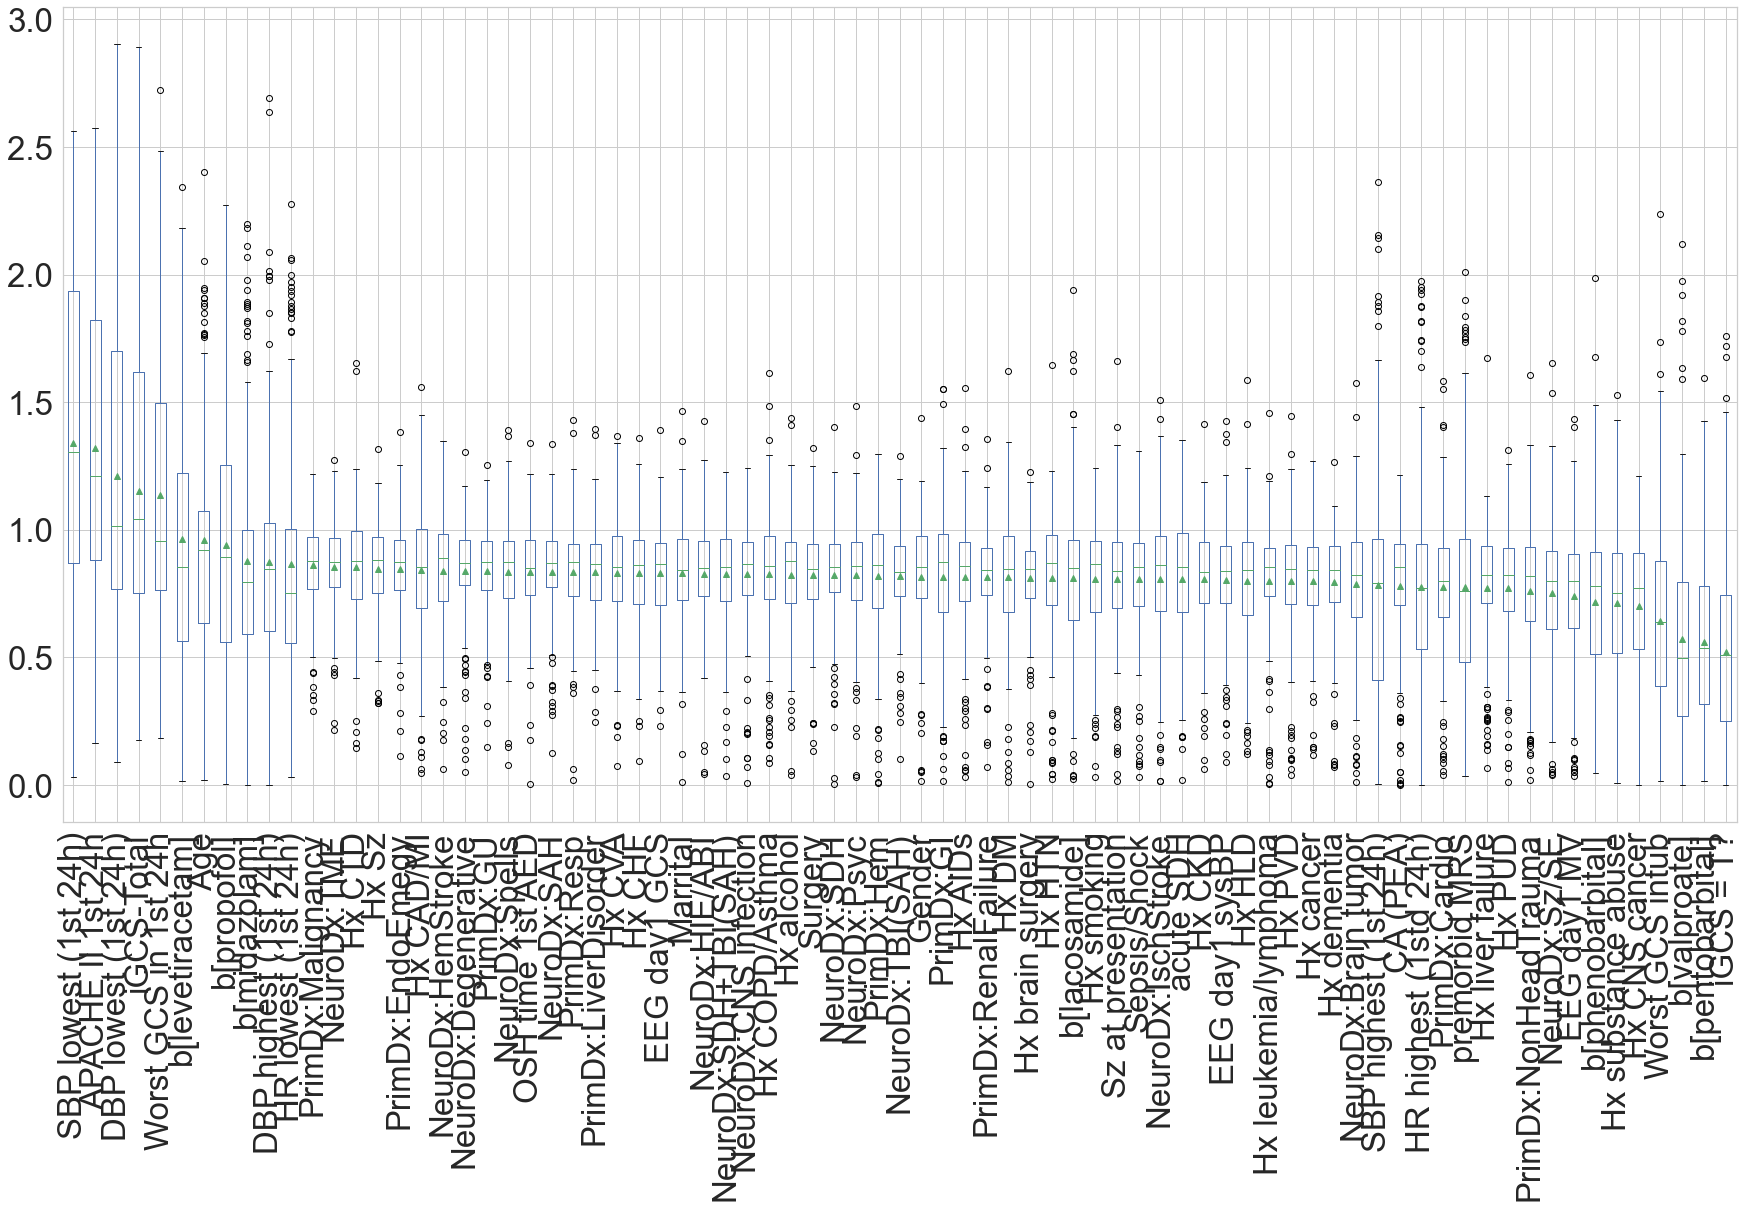

In [79]:
fig,ax = plt.subplots(figsize=(30,15))
columns_order = list(pd.concat(m.M_opt_list).mean(axis=0).sort_values(ascending=False).index)
pd.concat(m.M_opt_list)[columns_order].plot(kind='box',ax=ax,rot=90,showmeans=True)
pd.concat(m.M_opt_list)[columns_order].std(axis=0)/2
# plt.ylim(-0.001,1.0)

Text(0.5, 1.0, 'Controlling for Preadmission Covariates and PKPD Parameters')

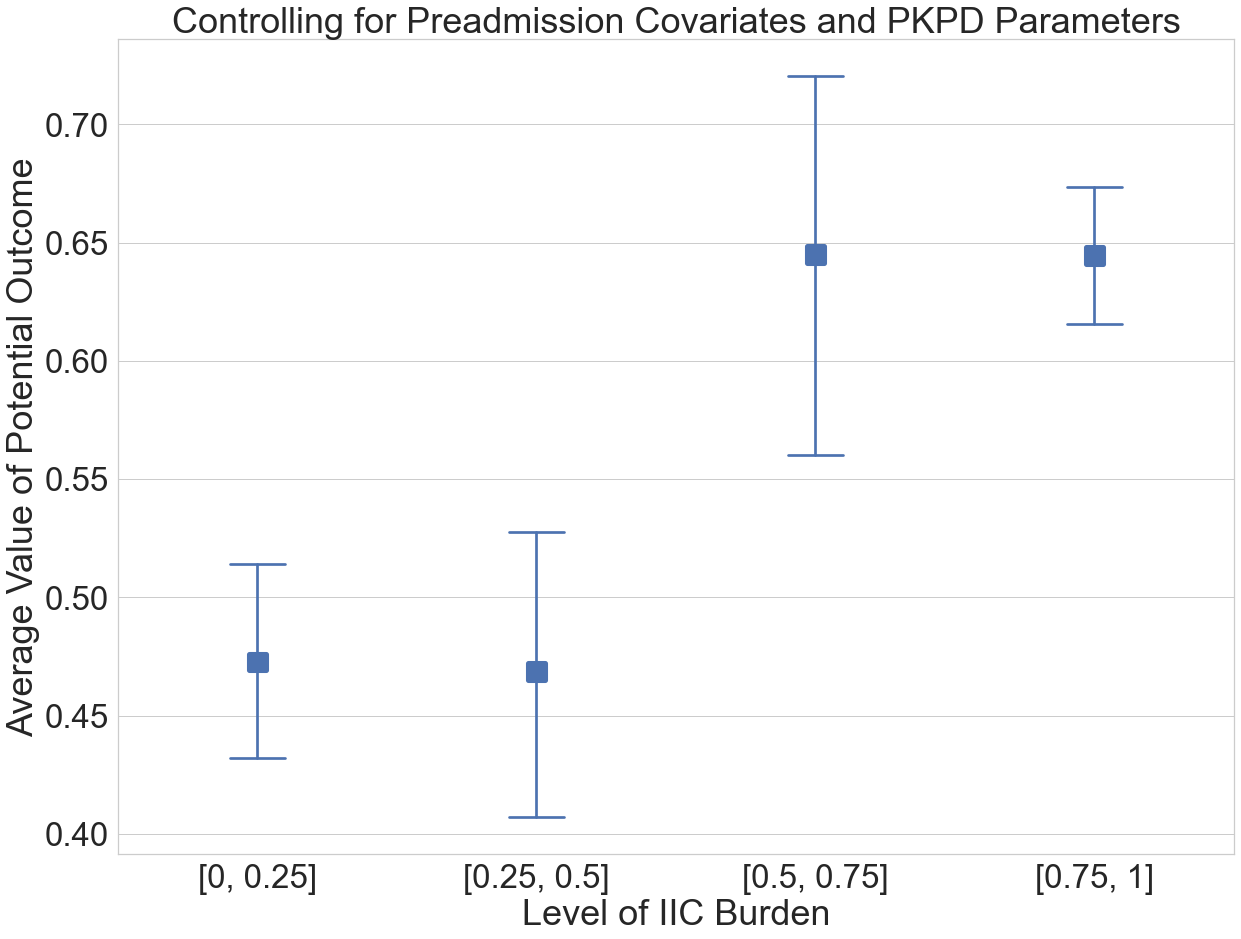

In [77]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_max_c_pkpd.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<620).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(apo_1_c_pkpd.values*(diam_1_c_pkpd<620).astype(int).replace(0, np.nan).values,
                         index=apo_1_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_1_c_pkpd.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], scale = 2.5)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
plt.title('Controlling for Preadmission Covariates and PKPD Parameters')
fig.savefig('new_max_c_pkpd.png')

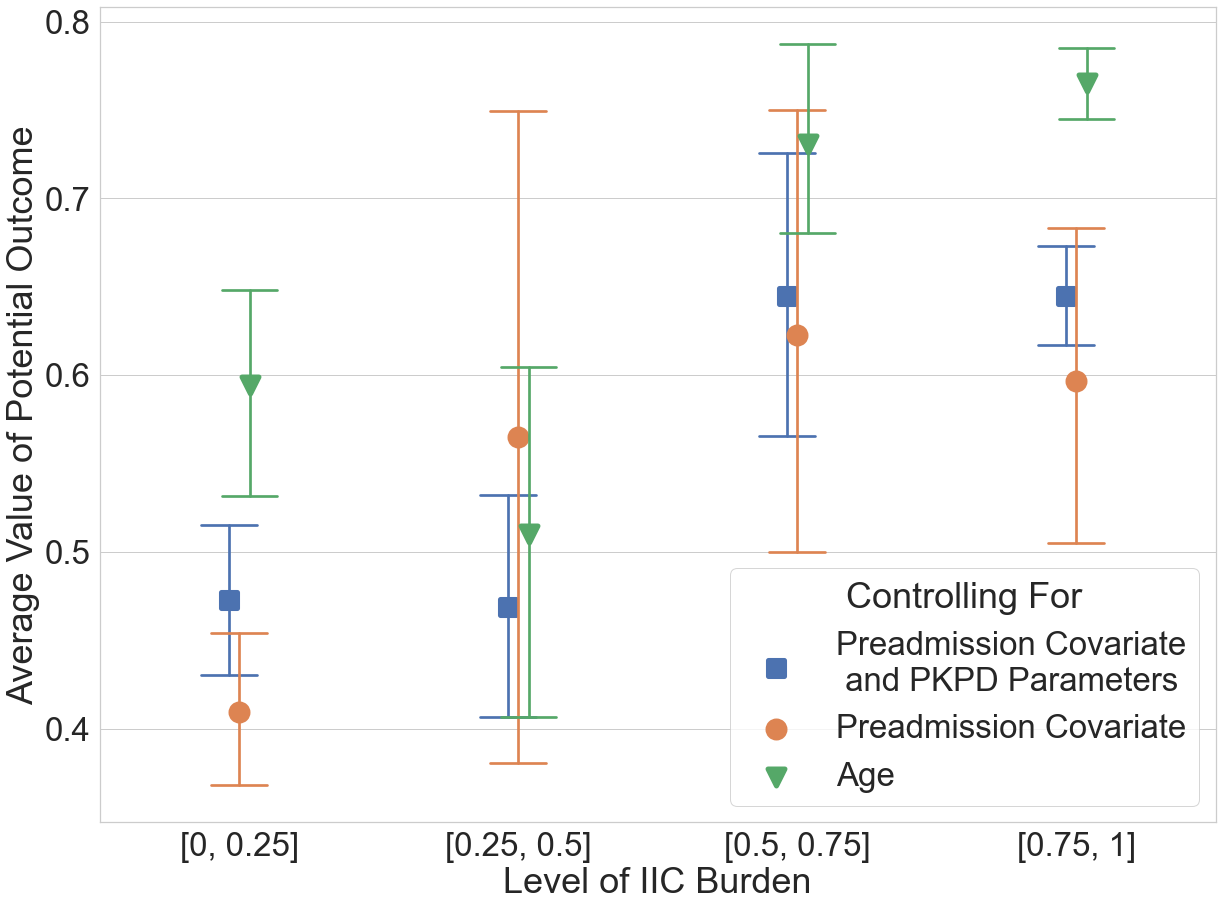

In [72]:
fig,ax = plt.subplots(figsize=(20,15))
control = ['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age']
df_apo = [apo_tight_0_c_pkpd,apo_tight_0_c,apo_tight_0]
df_plot = pd.DataFrame()
for i in range(3):
    df_plot_ = df_apo[i].mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'})
    df_plot_['Controlling For'] = [control[i] for k in range(df_plot_.shape[0])]
    df_plot = df_plot.append(df_plot_)

sns.pointplot(data=df_plot,
             x='index',y='Average Potential Outcome',
             hue='Controlling For',ax=ax,join=False,
             capsize=.2,markers=['s','o','v'],dodge=True,scale = 2.5)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max.png')

# Matched Group Analysis

In [183]:
MG = m.MG_matrix
MG_b = (MG>65).astype(int)
MG.to_csv('matched_group_matrix.csv')

In [184]:
G = nx.from_pandas_adjacency(MG_b)

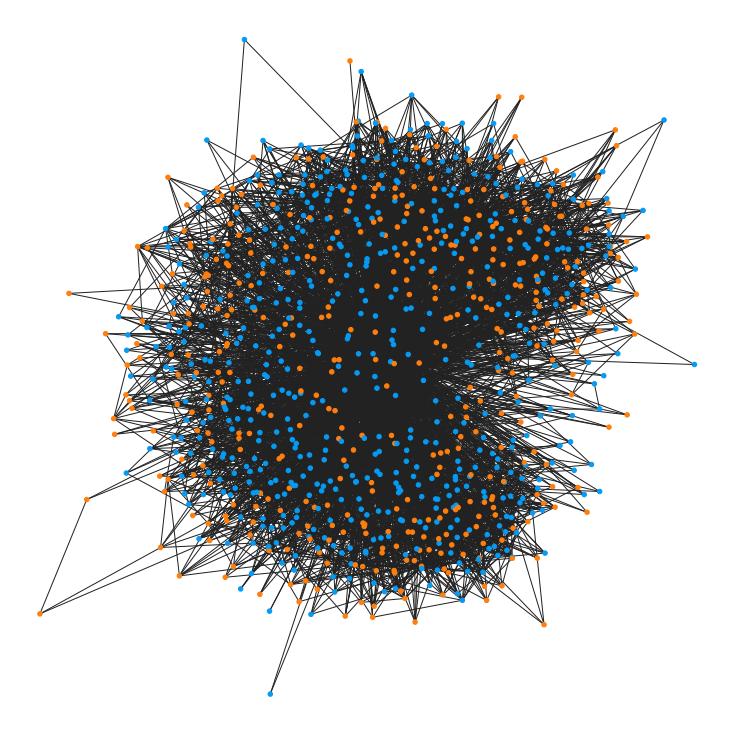

In [185]:
fig = plt.figure(figsize=(10,10))
node_color = [ '#ff7f0e' if df_malts_data.loc[i,'APACHE II 1st 24h']>20 else '#069af3' for i in (df_malts_data.index) ]
nx.draw(G,node_size=20,node_color=node_color,edge_color='#222222')

# Heterogeneous Effect

In [125]:
cate_df = m.CATE_df

In [157]:
df_apo_pkpd_c = cate_df[list(filter( lambda x: 'Y(' in x, cate_df.columns ))].T.reset_index().groupby(by='index').mean().T
df_apo_pkpd_c.to_csv('potential_outcome_pkpd_c.csv')

<AxesSubplot:ylabel='Density'>

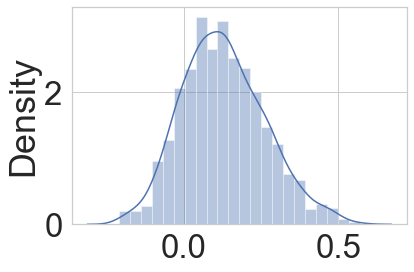

In [162]:
te = df_apo_pkpd_c['Y((0.88, 0))'] - df_apo_pkpd_c['Y((0.12, 0))'] 
sns.distplot(te)

In [190]:
hetero_te_m = {}
for col in ['NeuroDx:IschStroke', 
            'NeuroDx:HemStroke',
             'NeuroDx:SAH',
             'NeuroDx:SDH',
             'NeuroDx:SDH+TBI(SAH)',
             'NeuroDx:TBI(SAH)',
             'NeuroDx:Sz/SE',
             'NeuroDx:Brain tumor',
             'NeuroDx:CNS infection',
             'NeuroDx:HIE/ABI',
             'NeuroDx:TME',
             'NeuroDx:Psyc',
             'NeuroDx:Degenerative',
             'NeuroDx:Spells',
             'PrimDx:Resp',
             'PrimDx:Cardio',
             'PrimDx:RenalFailure',
             'PrimDx:LiverDisorder',
             'PrimDx:GI',
             'PrimDx:GU',
             'PrimDx:EndoEmegy',
             'PrimDx:NonHeadTrauma',
             'PrimDx:Malignancy',
             'PrimDx:Hem']:
    hetero_te_m[col] = tree.DecisionTreeRegressor(max_leaf_nodes=8,min_samples_leaf=15).fit(df_malts_data[[col]],te)

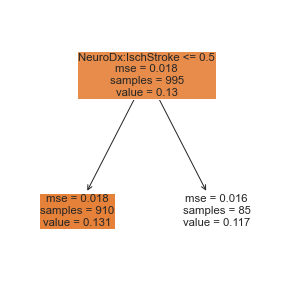

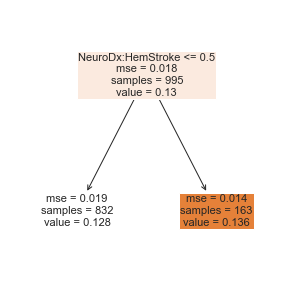

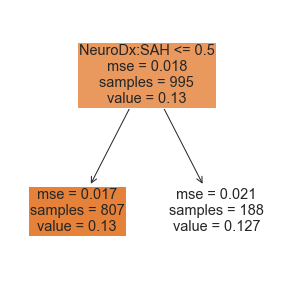

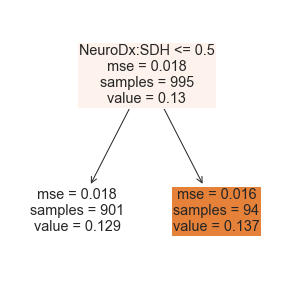

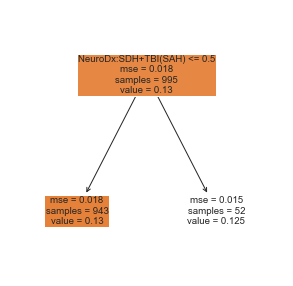

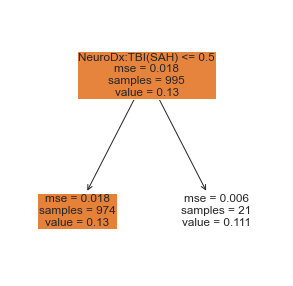

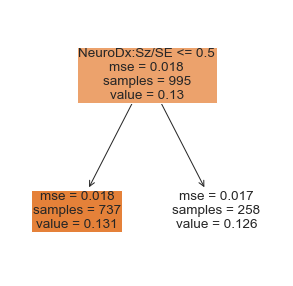

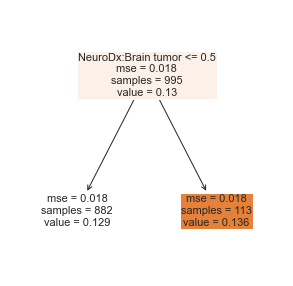

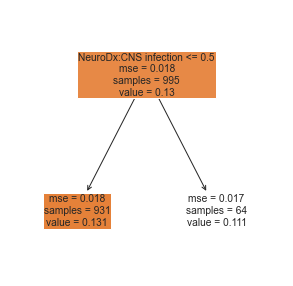

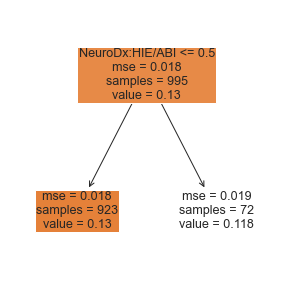

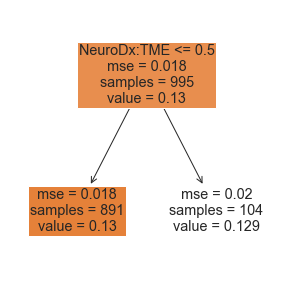

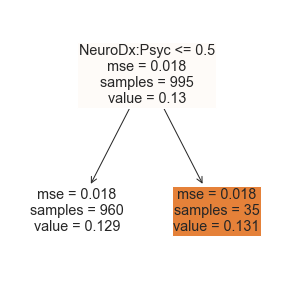

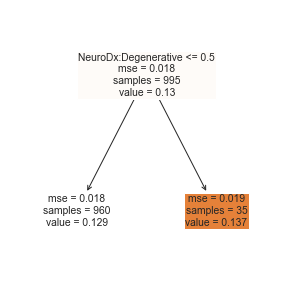

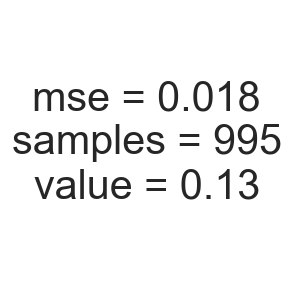

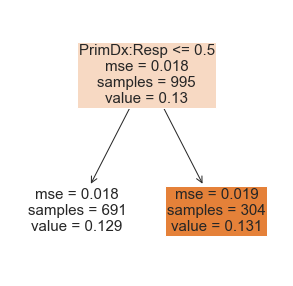

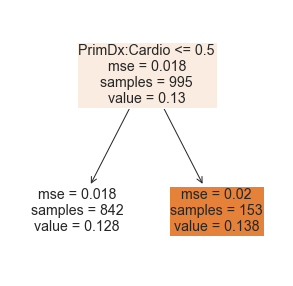

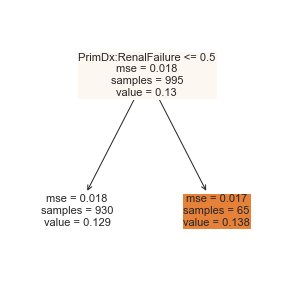

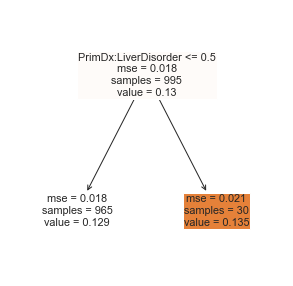

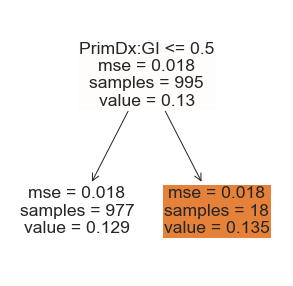

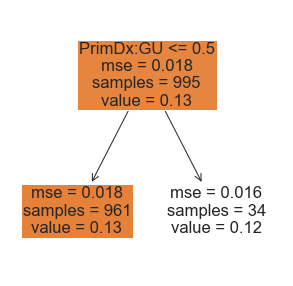

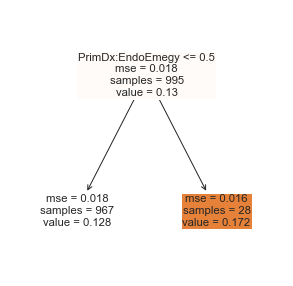

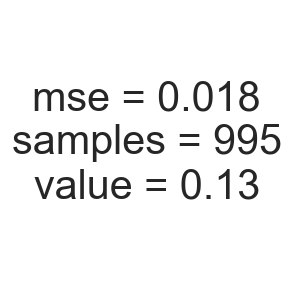

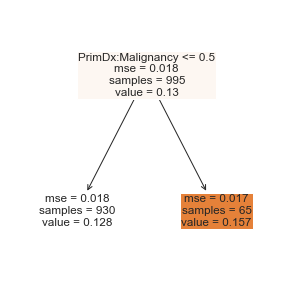

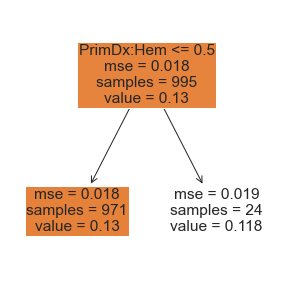

In [193]:
for col in ['NeuroDx:IschStroke', 
            'NeuroDx:HemStroke',
             'NeuroDx:SAH',
             'NeuroDx:SDH',
             'NeuroDx:SDH+TBI(SAH)',
             'NeuroDx:TBI(SAH)',
             'NeuroDx:Sz/SE',
             'NeuroDx:Brain tumor',
             'NeuroDx:CNS infection',
             'NeuroDx:HIE/ABI',
             'NeuroDx:TME',
             'NeuroDx:Psyc',
             'NeuroDx:Degenerative',
             'NeuroDx:Spells',
             'PrimDx:Resp',
             'PrimDx:Cardio',
             'PrimDx:RenalFailure',
             'PrimDx:LiverDisorder',
             'PrimDx:GI',
             'PrimDx:GU',
             'PrimDx:EndoEmegy',
             'PrimDx:NonHeadTrauma',
             'PrimDx:Malignancy',
             'PrimDx:Hem']:
    fig,ax = plt.subplots(figsize=(5,5))
    tree.plot_tree(hetero_te_m[col],feature_names=[col],filled=True)
    fig.savefig('hetero_tree_%s.png'%(col.replace(':','').replace('/','')))

In [ ]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 0) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 3*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [ ]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_c_pkpd.csv')

In [ ]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_c_pkpd.png')

In [ ]:
df_m_atec_dict['max']

In [ ]:
for type_summary in ['max','mean']:
    fig,ax = plt.subplots(figsize=(20,16))
    df_m_atec = df_m_atec_dict[type_summary]
#     for control_var in ['c_pkpd']:
#         df_m_atec =  pd.read_csv('df_m_atec_'+type_summary+'_'+control_var+'.csv').rename(columns={'Unnamed: 0':'index'})
    levels = list(df_m_atec.reset_index()['index'])
    df = pd.DataFrame(df_m_atec.reset_index().drop(columns=['index']).stack(level=0).droplevel(1),columns=['ATE'])
    df['Level'] = df.index
    sns.lineplot(x='Level',y='ATE',data=df,ci='sd')
    plt.xlim((0,2))
#     plt.legend(['Age','All Preadmission Covariates','All Preadmission Covariates \nand PKPD Parameters'],title="Controlling for")
    plt.xticks(np.arange(len(levels)),levels,rotation=90)
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('Estimated Causal Effect')
               # \n$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary)
    plt.xlabel('IIC Burden')
    plt.title('%s'%(type_summary))
#     fig.savefig(type_summary+'_line.png')

In [ ]:
pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum()

In [ ]:
df_means

# Heterogeneous Effects

In [ ]:
type_summary = 'max'
threshold = 0.8
df_analysis = df_dict_dict[type_summary][threshold].join(m_dict_dict[type_summary][threshold].CATE_df['avg.CATE']).loc[(df_dict_dict[type_summary][threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict_dict[type_summary][threshold]['propofol']<=1) 
                                                                       & (df_dict_dict[type_summary][threshold]['midazolam']<=0.1)
                                                                       & (df_dict_dict[type_summary][threshold]['lacosamide']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['pentobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['phenobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['valproate']<=0)
                                                                       & (m_dict_dict[type_summary][threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])]

In [ ]:
import sklearn.tree as tree

In [ ]:
ex_model = tree.DecisionTreeRegressor(max_leaf_nodes=8,min_samples_leaf=15,min_impurity_decrease=0.0001).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])
# df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]','premorbid MRS before admission  (modified ranking scale),before admission'])

In [ ]:

fig,ax = plt.shetero_te_mlots(figsize=(20,15))
tree.plot_tree(ex_model,feature_names=df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).rename(columns={'premorbid MRS before admission  (modified ranking scale),before admission':'preadmission mRS','iMV  (initial (on admission) mechanical ventilation)':'mechanical ventilation'}).columns,filled=True)

In [ ]:
import sklearn.ensemble as en

In [ ]:
ex_model_ada = en.AdaBoostRegressor(n_estimators=1000).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])

In [ ]:
df_analysis['avg.CATE']

In [ ]:
age_range = np.arange(18,80)
dumy_x_0 = np.zeros((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_1 = np.ones((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_0[:,1] = age_range
dumy_x_1[:,1] = age_range
acc_res_0 = 0
acc_res_1 = 0
counter = 0
for estimator in ex_model_ada.estimators_:
    if estimator.feature_importances_[1]>0:
        acc_res_0 += estimator.predict(dumy_x_0)
        acc_res_1 += estimator.predict(dumy_x_1)
        counter += 1
acc_res_0 = acc_res_0/counter
acc_res_1 = acc_res_1/counter

In [ ]:
sns.regplot(age_range,acc_res_0,order=4,scatter=False)
sns.regplot(age_range,acc_res_1,order=4,scatter=False)

In [ ]:
for type_summary in m_dict_dict.keys():
    for threshold in m_dict_dict[type_summary].keys():
        m_dict_dict[type_summary][threshold].CATE_df.to_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10))
        m_dict_dict[type_summary][threshold].MG_matrix.to_csv('MG_%s_%.0f.csv'%(type_summary,threshold*10))
        df_dict_dict[type_summary][threshold].to_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10))
    df_means_dict[type_summary].to_csv('descriptive_summary_estimation_set_%s.csv'%(type_summary))

In [ ]:
age_range = np.arange(18,80)

In [ ]:
age_range

In [ ]:
df_control_max = df_dict_dict['max'][0.8].loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
sns.scatterplot(data=df_control_max,y='Y',x='Age')

In [ ]:
columns = ['20-40','40-60','70+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat = np.zeros((2,3))
for i in df_control_max.index:
    age = df_control_max.loc[i,'Age']
    y = df_control_max.loc[i,'Y']
    if age<40:
        mat[int(y),0] += 1
    elif age<60:
        mat[int(y),1] += 1
    elif age>60:
        mat[int(y),2] += 1
mat[:,0] = mat[:,0]*100.0/np.sum(mat[:,0])
mat[:,1] = mat[:,1]*100.0/np.sum(mat[:,1])
mat[:,2] = mat[:,2]*100.0/np.sum(mat[:,2])
df_mat = pd.DataFrame(mat,columns=columns,index=index)

In [ ]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat,annot=True,cmap="RdBu_r")
plt.ylabel('$Y(e \\in [0\%,10\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y0_age.png')

In [ ]:
m_dict_dict['max'][0.8].CATE_df.loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
type_summary = 'max'
threshold = 0.8
gph = m_dict_dict[type_summary][threshold].MG_matrix

In [ ]:
import networkx

In [ ]:
G_max_8 = networkx.from_pandas_adjacency((gph>24).astype(int))

In [ ]:
fig = plt.figure(figsize=(10,10))
node_color = [ 'red' if df_dict_dict[type_summary][threshold].loc[i,'T']==1 else 'blue' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=10,node_color=node_color)

In [ ]:
fig = plt.figure(figsize=(10,8))
node_color = [ '#ff7f0e' if df_dict_dict[type_summary][threshold]['iMV  (initial (on admission) mechanical ventilation)'].loc[i]==1 else '#069af3' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=20,node_color=node_color,edge_color='#222222')
fig.savefig('iMV_mg_c_pkpd_viz.png')

In [ ]:
df_dict_dict[type_summary][threshold].columns

In [ ]:
tightest_matched_units = m_dict_dict['max'][0.8].CATE_df.sort_values(by='avg.Diameter').iloc[:10].index
tightest_mg = (m_dict_dict['max'][0.8].MG_matrix.loc[tightest_matched_units]>24)

In [ ]:
for i in tightest_mg.index:
    mg_i = tightest_mg.loc[i]
    mg_i = mg_i[mg_i>0].index
    df_dict_dict['max'][0.8].loc[mg_i].to_csv('matched_group_%s_24_c_pkpd.csv'%(str(i)))

In [ ]:
df_dict_dict['max'][0.8].loc[mg_i]